# Machine learning technique for signal-background separation of nuclear interaction vertices in the CMS detector
Analysis is staring from csv-file (no pyRoot).

## Abstract:
The CMS inner tracking system is a fully silicon-based high precision detector. Accurate knowledge of the positions of active and inactive elements is important for simulating the detector, planning detector upgrades, and reconstructing charged particle tracks. Nuclear interactions of hadrons with the detector material create secondary vertices whose positions map the material with a sub-millimeter precision in situ, while the detector is collecting data from LHC collisions. 

A neural network (NN) with two hidden layers was used to separate secondary vertices due to combinatorial background from those arising from nuclear interactions with material. The NN was trained and tested on data from proton-proton collisions at a center-of-mass energy of 13 TeV, recorded in 2018 at the LHC. 

NN training is performed using Keras and Matplotlib in a Jupyter notebook. Secondary vertices in the training data are classified as signal or background, based on their geometrical position. Even though the variables used in training show only small differences between background and signal, the NN has impressive separation power. Tomographies of the CMS inner tracker detector before and after background cleaning are presented.

## Table of contents
* [Data preparation for NN](#Data)

  * [Import libraries and connect data](#Import-data)
  * [Set Signal and Background regions for BPIX](#SetBPIX)
  * [Set Signal and Background regions for beam pipe](#SetBP)
  * [Set Signal and Background regions for pixel support tube](#SetTube)
  * [Set Signal and Background regions  for rails, by using  x positon of NI](#SetRails)
  * [Classify events as Signal, as Background, and as Unclassified regions (-1)](#ClassifyEvents)
  * [Split data to Train and Test sets after shuffling](#DataSplit)
  * [Check classification result](#CheckClassification)  
  * [Plot variables, injected to NN](#VariablesToNN)
* [Keras mode: NN with 2 hidden layers](#KerasModel)
  * [Import libraries](#ImportKeras)
  * [Create function for NN model with 2 hidden layers](#NNfunction)
  * [Create final classification, by keeping numSig classes for Singnal and numBkg classes for Background](#FinalClassification)
  * [Creat NN model structure and compile it](#ModelCompile)
  * [NN model training](#ModelTraining)
  * [Save/Load NN model to/from file](#Save-Load-Model)
  * [Monitor performance during training](#MonitorTraining)
  * [Model Results](#ModelResults)
     * [Predict Y for Train and Test sets](#PredictY)
     * [Plot Y prediction of Test set for n-th class](#PlotY)
     * [Set threshold for Signal-Background seperation](#SetYthreshold)
     * [Plot Train and Test prediction for Signal-Background seperation as function of  BPIX radius](#PlotPredictedResultsR)
     * [Tracker tomography with Test set for Signal-Background seperation in x-y plane](#PlotPredictedTomography)


# Data preparation for NN <a class="anchor" id="Data"></a>

## Import libraries and connect data <a class="anchor" id="Import-data"></a>

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 

data = np.genfromtxt("/eos/user/k/kropiv/root-files/NI/NN_X_2018D_barrel.csv", delimiter=',')
print ("shape of data = " + str(data.shape))

shape of data = (1397381, 27)


## Set Signal and Background regions for BPIX <a class="anchor" id="SetBPIX"></a>

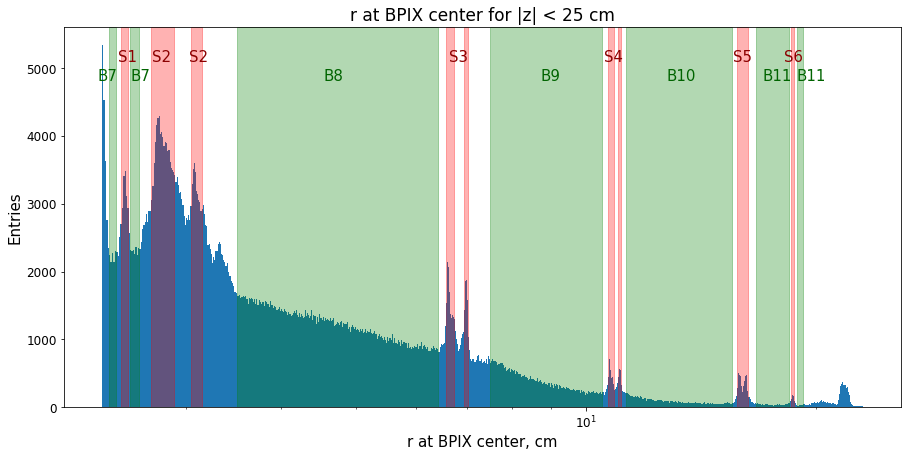

In [2]:
def makeBand(xStart, xWidth, px, bandColor):
    transperance = 0.3
    for p, lw in zip(xStart,xWidth):
        #plt.axvline(p, color=bandColor, alpha = transperance)
        px.axvspan(p, p+lw, alpha = transperance, color=bandColor)

def makeSBtext(xPos,yPos, px, text, textColor, fontS = 15):
    for i_xPos, i_text in zip(xPos,text):
        px.text(i_xPos, yPos, i_text,
                verticalalignment='bottom', horizontalalignment='left',
                transform=px.transAxes, color=textColor, fontsize=fontS)
    

plt.rc('axes', labelsize = 15)
plt.rc('axes', titlesize= 17)
plt.rc('font', size=12) 
plt.rc('legend', fontsize=15)

# the histogram of the data
Radius = np.sqrt(np.square(data[:,1])+np.square(data[:,2]))
Radius_BP = np.sqrt(np.square(data[:,1]-0.171)+np.square(data[:,2]+0.176))
Radius_BPIX = np.sqrt(np.square(data[:,1]-0.086)+np.square(data[:,2]+0.102))
Radius_Tube = np.sqrt(np.square(data[:,1]+0.080)+np.square(data[:,2]+0.318))

# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
num_bins = 2000

#n, bins, patches = ax.hist(Radius[Radius < 25], num_bins)

#correction to BPIX
#n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(Radius_BPIX >2.33, Radius_BPIX <4)], num_bins)
n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(Radius_BPIX >2.33, Radius_BPIX <23)], num_bins)
# n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(np.logical_and(Radius_BPIX >2.33, Radius_BPIX <23),
#                                                       data[:,4] < 15)], num_bins)
# ax.set_xlim(2.33,23)
#plt.xlim(17,21)

# add a 'best fit' line
#y_min = (2.7)
#ax.plot(bins, y_min, '--')

#          Inner Shield      L1_1    L1_2    L2_1  L2_2     L3_1   L3_2      L4_1_2 Outer Shield      
xSignal_BPIX = [2.47,        2.7,    3.05,   6.56, 6.93,    10.68, 11.01,    15.75, 18.53]
lw_Signal_BPIX =  [0.055,    0.2,    0.1,    0.17,  0.09,     0.2,  0.12,      0.55, 0.2]
#lw_Signal_BPIX =  [0.055,       0.2, 0.1,    0.1,  0.09,     0.2,  0.12,      0.55, 0.2]
makeBand(xSignal_BPIX, lw_Signal_BPIX, ax, "red")

#              BP-S    S-L1    L1-L2  L2-L3  L3-L4   L4-OS   OS-Rails
xBkg_BPIX =   [2.38,   2.54,   3.5,   7.5,   11.3,   16.7,   18.9]
lw_Bkg_BPIX = [0.05,   0.07,   2.9,   3.0,   4.2,    1.7,    0.3]
makeBand(xBkg_BPIX, lw_Bkg_BPIX, ax, "green")
            
#n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(Radius_BPIX >2.4, Radius_BPIX <18)], num_bins)
Xtitle = "r at BPIX center"

# correcton to pixel support tube
#n, bins, patches = ax.hist(Radius_Tube[np.logical_and(Radius_Tube >20, Radius_Tube <25)], num_bins)
#Xtitle = "R_tube"

ax.set_xlabel(Xtitle+', cm')
ax.set_ylabel('Entries')
ax.set_title(Xtitle+' for |z| < 25 cm')

yBkgPos = 0.85
#background   befor L1    L1-L2 L2-L3 L3-L4  L4-TIB1
xBkgPos =    [0.04, 0.08, 0.31, 0.57, 0.72,  0.835, 0.875]
textPos =    ["B7", "B7", "B8", "B9", "B10", "B11", "B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.9
#Signal    IS     L1           L2    L3     L4    OS
xSPos =   [0.065, 0.105, 0.15, 0.46, 0.646, 0.8,  0.86]
textPos = ["S1",  "S2",  "S2", "S3", "S4",  "S5", "S6"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
plt.xscale('log')
#plt.yscale('log')
plt.savefig('Results/R_atBPIX.pdf')
plt.show()


## Set Signal and Background regions for beam pipe <a class="anchor" id="SetBP"></a>

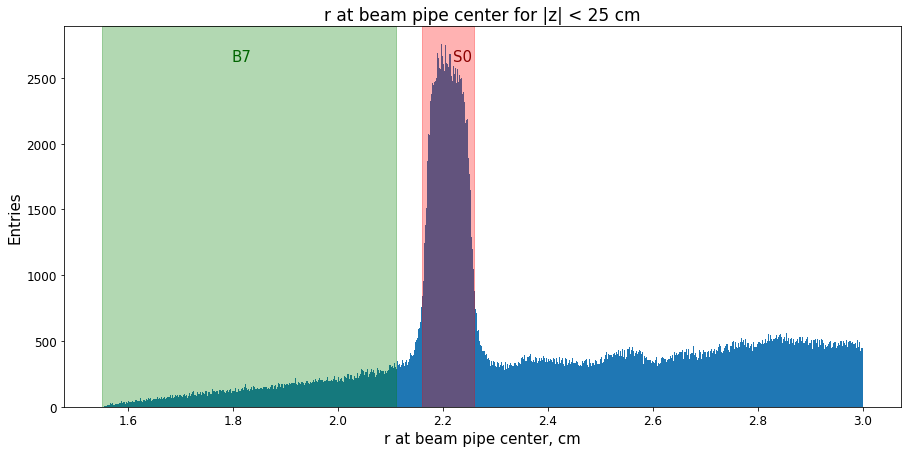

In [3]:
# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
#num_bins = 180
num_bins = 1000

#correction to beam pipe
n, bins, patches = ax.hist(Radius_BP[Radius_BP < 3], num_bins)
#n, bins, patches = ax.hist(data[:,4][data[:,4] < 60], num_bins)
Xtitle = "r at beam pipe center"
#                BP      
xSignal_BP =    [2.16]
lw_Signal_BP =  [0.1]
makeBand(xSignal_BP, lw_Signal_BP, ax, "red")

#           before BP
xBkg_BP =   [1.55]
lw_Bkg_BP = [0.56]
makeBand(xBkg_BP, lw_Bkg_BP, ax, "green")

ax.set_xlabel(Xtitle+', cm')
ax.set_ylabel('Entries')
ax.set_title(Xtitle+' for |z| < 25 cm')

yBkgPos = 0.9
#background   befor BP
xBkgPos =    [0.2]
textPos =    ["B7"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.9
#Signal    BP
xSPos =   [0.465]
textPos = ["S0"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

plt.savefig('Results/R_atBeamPipe.pdf')
plt.show()


## Set Signal and Background regions for pixel support tube <a class="anchor" id="SetTube"></a>

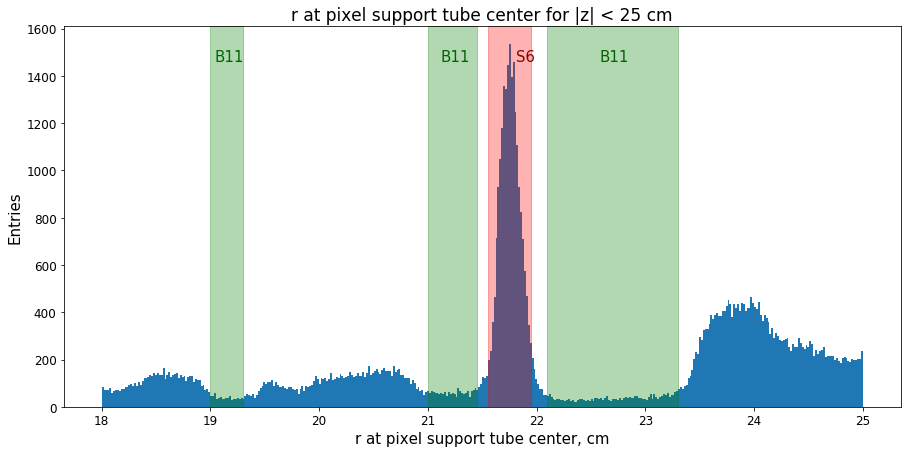

In [4]:
# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
num_bins = 400

#correction to pixel support tube
n, bins, patches = ax.hist(Radius_Tube[np.logical_and(Radius_Tube >18, Radius_Tube <25)], num_bins)
Xtitle = "r at pixel support tube center"

#                  Tube     
xSignal_Tube   =  [21.55]
lw_Signal_Tube =  [0.4]
makeBand(xSignal_Tube, lw_Signal_Tube, ax, "red")

#             OS-Tube Rails-Tube Tube-TIB1
xBkg_Tube =   [19.,   21.,       22.1]
lw_Bkg_Tube = [0.3,   0.45,      1.2]
makeBand(xBkg_Tube, lw_Bkg_Tube, ax, "green")

ax.set_xlabel(Xtitle+', cm')
ax.set_ylabel('Entries')
ax.set_title(Xtitle+' for |z| < 25 cm')

#plt.xscale('log')
#plt.yscale('log')

yBkgPos = 0.9
#background   L4-TIB1
xBkgPos =    [0.18, 0.45, 0.64]
textPos =    ["B11", "B11", "B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.9
#Signal    BPIX support tube
xSPos =   [0.54]
textPos = ["S6"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

plt.savefig('Results/R_atTube.pdf')
plt.show()

## Set Signal and Background regions  for rails, by using  x positon of NI ($\phi$ could be used too) <a class="anchor" id="SetRails"></a>

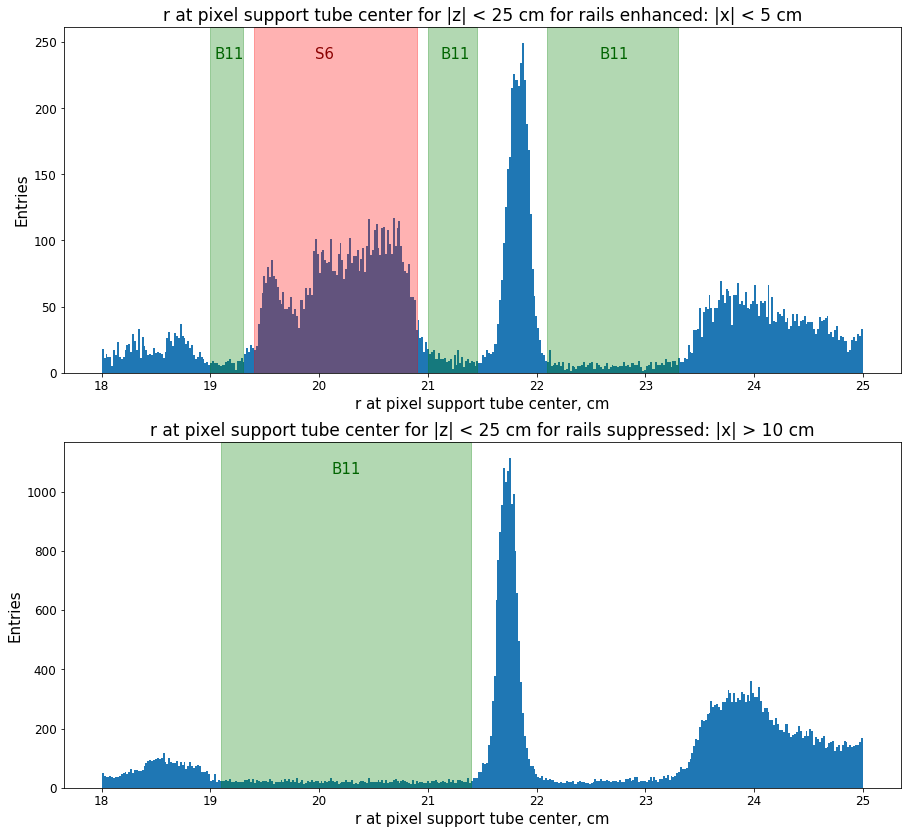

In [5]:
# using the variable ax for single a Axes
fig, (ax,bx) = plt.subplots(2,1, figsize=(15,14))
num_bins = 400

#correction to pixel support tube
n, bins, patches = ax.hist(Radius_Tube[np.logical_and(np.logical_and(Radius_Tube >18, Radius_Tube <25), 
                                                      np.logical_and(data[:,1]> -5, data[:,1]<5))], num_bins)
n_b, bins_b, patches_b = bx.hist(Radius_Tube[np.logical_and(np.logical_and(Radius_Tube >18, Radius_Tube <25), 
                                                            np.logical_or(data[:,1]< -10, data[:,1]>10))], num_bins)
Xtitle = "r at pixel support tube center"

#                  Rails     
xSignal_Rails   =  [19.4]
lw_Signal_Rails =  [1.5]
makeBand(xSignal_Rails, lw_Signal_Rails, ax, "red")

# the same background as for pixel support tube:
makeBand(xBkg_Tube, lw_Bkg_Tube, ax, "green")

ax.set_xlabel(Xtitle+', cm')
ax.set_ylabel('Entries')
ax.set_title(Xtitle+' for |z| < 25 cm for rails enhanced: |x| < 5 cm')


#                 noRails region: |PFDV_X| > 10 cm, PFDV_X = data[:,1]
xBkg_noRails =   [19.1]
lw_Bkg_noRails = [2.3]
makeBand(xBkg_noRails, lw_Bkg_noRails, bx, "green")
bx.set_xlabel(Xtitle+', cm')
bx.set_ylabel('Entries')
bx.set_title(Xtitle+' for |z| < 25 cm for rails suppressed: |x| > 10 cm')

#plt.xscale('log')
#plt.yscale('log')

yBkgPos = 0.9
#background   L4-TIB1
xBkgPos =    [0.18, 0.45, 0.64]
textPos =    ["B11", "B11", "B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.9
#Signal    BPIX rails
xSPos =   [0.3]
textPos = ["S6"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

yBkgPos = 0.9
#background   L4-TIB1
xBkgPos =    [0.32]
textPos =    ["B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, bx, textPos, "darkgreen")

plt.savefig('Results/R_atTube_forRails.pdf')
plt.show()

## Classify events as Signal, as Background, and as Unclassified regions (-1) <a class="anchor" id="ClassifyEvents"></a>

In [7]:
def SetYval(xStart, xWidth, Yval, Rad):    
    for p, lw, yVal in zip(xStart, xWidth, Yval):
        logicVal = np.logical_and(Rad > p, Rad < (p+lw))
        # reshape from (n,) to (n,1)
        #logicVal = logicVal.reshape(Y.shape)
        # assinge yVal only if logicVal
        Y[logicVal] = yVal

def SetYvalRails(xStart, xWidth, Yval, Rad):
    for p, lw, yVal in zip(xStart, xWidth, Yval):
        logicVal = np.logical_and(np.logical_and(Rad > p, Rad < (p+lw)),
                                  np.logical_and(data[:,1] > -5, data[:,1] < 5))
        # assinge yVal only if logicVal
        Y[logicVal] = yVal        
def SetYvalnoRails(xStart, xWidth, Yval, Rad):
    for p, lw, yVal in zip(xStart, xWidth, Yval):
        logicVal = np.logical_and(np.logical_and(Rad > p, Rad < (p+lw)),
                                  np.logical_or(data[:,1] < -10, data[:,1] > 10))
        # assinge yVal only if logicVal
        Y[logicVal] = yVal 
        
print ("data shape = "+str(data.shape))
Y = np.zeros((data.shape[0])) - 1
print ("shape of Y = " +str(Y.shape))

#Define values for Y: 0-6 - Signal, 7-11 - Background:

#          Inner Shield L1_1 L1_2    L2_1  L2_2     L3_1   L3_2      L4_1_2 Outer Shield 
Y_Signal_BPIX = [1,     2,   2,      3,    3,       4,     4,        5,     6]
print("Signal       BPIX = " + str(xSignal_BPIX))
print("Signal width BPIX = " + str(lw_Signal_BPIX))
#              BP-S    S-L1    L1-L2  L2-L3  L3-L4   L4-OS   OS-Rails
Y_Bkg_BPIX =   [7,     7,      8,     9,     10,     11,     11]
print("Bkg          BPIX = " + str(xBkg_BPIX))
print("BKg    width BPIX = " + str(lw_Bkg_BPIX))

Y_Signal_BP = [0]
print("Signal       BP = " + str(xSignal_BP))
print("Signal width BP = " + str(lw_Signal_BP))
Y_Bkg_BP = [7]
print("Bkg          BP = " + str(xBkg_BP))
print("Bkg    width BP = " + str(lw_Bkg_BP))

# Tube
Y_Signal_Tube = [6]
print("Signal       Tube = " + str(xSignal_Tube))
print("Signal width Tube = " + str(lw_Signal_Tube))
#             OS-Tube Rails-Tube Tube-TIB1
Y_Bkg_Tube = [11, 11, 11]
print("Bkg          Tube = " + str(xBkg_Tube))
print("Bkg    width Tube = " + str(lw_Bkg_Tube))

# Special case for Rails with cut on PFDV_X
#                 Rails region: |PFDV_X| < 5 cm, PFDV_X = data[:,1]
#                 the same background as for Tube
Y_Signal_Rails = [6]
print("Signal       Rails = " + str(xSignal_Rails))
print("Signal width Rails = " + str(lw_Signal_Rails))
#                 noRails region: |PFDV_X| > 10 cm, PFDV_X = data[:,1]
#             OS-Tube
Y_Bkg_noRails = [11]
print("Bkg          noRails = " + str(xBkg_noRails))
print("Bkg    width noRails = " + str(lw_Bkg_noRails))

# Set up valuse for Y: start with Singnal, finish with Background

SetYval(xSignal_BPIX, lw_Signal_BPIX, Y_Signal_BPIX, Radius_BPIX)
SetYval(xBkg_BPIX, lw_Bkg_BPIX, Y_Bkg_BPIX, Radius_BPIX)
#print (str(Y[500:700]))
SetYval(xSignal_BP, lw_Signal_BP, Y_Signal_BP, Radius_BP)
SetYval(xBkg_BP, lw_Bkg_BP, Y_Bkg_BP, Radius_BP)
SetYval(xSignal_Tube, lw_Signal_Tube, Y_Signal_Tube, Radius_Tube)
SetYval(xBkg_Tube, lw_Bkg_Tube, Y_Bkg_Tube, Radius_Tube)
#print (str(Y[500:700]))
SetYvalRails(xSignal_Rails, lw_Signal_Rails, Y_Signal_Rails, Radius_Tube)
SetYvalnoRails(xBkg_noRails, lw_Bkg_noRails, Y_Bkg_noRails, Radius_Tube)
#print (str(Y[500:700]))

print ("count (Y >= 0) = %d " % (np.count_nonzero(Y >= 0)))
for i in range(-1,12):
    print ("count (Y = %d) = %d " % (i, np.count_nonzero(Y == i)))

data shape = (1397381, 27)
shape of Y = (1397381,)
Signal       BPIX = [2.47, 2.7, 3.05, 6.56, 6.93, 10.68, 11.01, 15.75, 18.53]
Signal width BPIX = [0.055, 0.2, 0.1, 0.17, 0.09, 0.2, 0.12, 0.55, 0.2]
Bkg          BPIX = [2.38, 2.54, 3.5, 7.5, 11.3, 16.7, 18.9]
BKg    width BPIX = [0.05, 0.07, 2.9, 3.0, 4.2, 1.7, 0.3]
Signal       BP = [2.16]
Signal width BP = [0.1]
Bkg          BP = [1.55]
Bkg    width BP = [0.56]
Signal       Tube = [21.55]
Signal width Tube = [0.4]
Bkg          Tube = [19.0, 21.0, 22.1]
Bkg    width Tube = [0.3, 0.45, 1.2]
Signal       Rails = [19.4]
Signal width Rails = [1.5]
Bkg          noRails = [19.1]
Bkg    width noRails = [2.3]
count (Y >= 0) = 950473 
count (Y = -1) = 446908 
count (Y = 0) = 153558 
count (Y = 1) = 16735 
count (Y = 2) = 104251 
count (Y = 3) = 40327 
count (Y = 4) = 15061 
count (Y = 5) = 19907 
count (Y = 6) = 29186 
count (Y = 7) = 81033 
count (Y = 8) = 333339 
count (Y = 9) = 108022 
count (Y = 10) = 35308 
count (Y = 11) = 13746 


## Split data to Train and Test sets after shuffling <a class="anchor" id="DataSplit"></a>

Important: 

before shuffling random seed was fixed to result to the same splitting for Train and Test sets each time running the code. It is nessasary for using trained model: we have to know on which data model was trained.  

In [8]:
#X_NN = data[:,4:27] # it will be set later, because we need to know R for Test set to plot it...
X_NN = data

# set rendom seed to avoid different spitting for Train and Test sets each time
np.random.seed(1)
perm = np.random.permutation(X_NN.shape[0])
print ("shape of perm = " + str(perm.shape))
#print ("perm = " + str(perm[1:100]))

# permutate X_NN and Y: remove bias, when some parts of detector where not working for exampe...
X_NN = X_NN[perm]
Y_NN    = Y[perm]

fracTrain = 0.5 # set Tainning fraction of data
NumTrain = (np.rint(X_NN.shape[0]*fracTrain)).astype(int)
# batchSize = 1024
# NumTrain = (np.rint(X_NN.shape[0]/batchSize*fracTrain)).astype(int)*batchSize # useless here because we skip "-1" events during training 

#print ("        NumTrain = "+str(NumTrain))
#print ("type of NumTrain = "+str(NumTrain.dtype))
X_Train = X_NN[:NumTrain,:]
X_Test  = X_NN[NumTrain:,:]
Y_Train = Y_NN[:NumTrain]
Y_Test  = Y_NN[NumTrain:]
print("Y_Train = "+str(Y_Train[0:200]))
 
print("shape X_Train = " + str(X_Train.shape))
print("shape X_Test = " + str(X_Test.shape))

# should be selected Y > -1 only for Train sample: use data with defined Y (Y > -1)
#and only after clean Train sample only
print ("count (Y_Train >= 0) = %d " % (np.count_nonzero(Y_Train >= 0)))
for i in range(-1,12):
    print ("count (Y_Train = %d) = %d " % (i, np.count_nonzero(Y_Train == i)))

shape of perm = (1397381,)
Y_Train = [ 8. 10.  7.  8.  2.  8.  0.  0.  3.  6.  8. -1.  8.  0. -1.  8.  8. -1.
  7. -1.  3.  8.  9. -1. -1.  2.  8. -1. -1.  8.  3. -1.  8.  9.  9.  8.
 -1. -1.  0. -1.  0. -1. -1. -1.  0. -1. -1.  8. -1. -1.  8.  8.  8.  8.
  9. -1.  8. -1. -1. 11. -1.  7.  8.  8.  2.  8.  9.  2. -1. -1.  0. -1.
  6.  3.  8. -1.  8.  2.  9. -1.  8. -1. -1. -1.  8.  2.  9. -1. -1. 10.
 -1.  9.  7.  9. -1.  5.  9.  9.  7. -1.  9.  4.  4.  9.  0.  8. -1. -1.
  8. -1.  2. -1.  8. -1. -1. -1. -1. -1. -1. -1.  0. -1.  7. -1. 10. -1.
  9.  8.  8.  7.  8.  8.  8.  2.  7.  8. 10.  9.  8.  8. -1.  9.  2.  7.
  8.  2. 10.  8.  5. -1. -1.  9.  8. -1.  9.  7.  3.  3.  8. -1.  0.  2.
  7.  8.  8. -1.  8.  8.  2. -1.  8. -1.  8.  8.  2.  8. -1.  8.  0. 10.
  9.  8. -1.  8.  8. -1.  8.  2.  4.  8. -1. -1. -1. -1.  8. -1. -1.  3.
  6.  8.]
shape X_Train = (698690, 27)
shape X_Test = (698691, 27)
count (Y_Train >= 0) = 475645 
count (Y_Train = -1) = 223045 
count (Y_Train = 0) = 76452 
co

## Check classification result <a class="anchor" id="CheckClassification"></a>

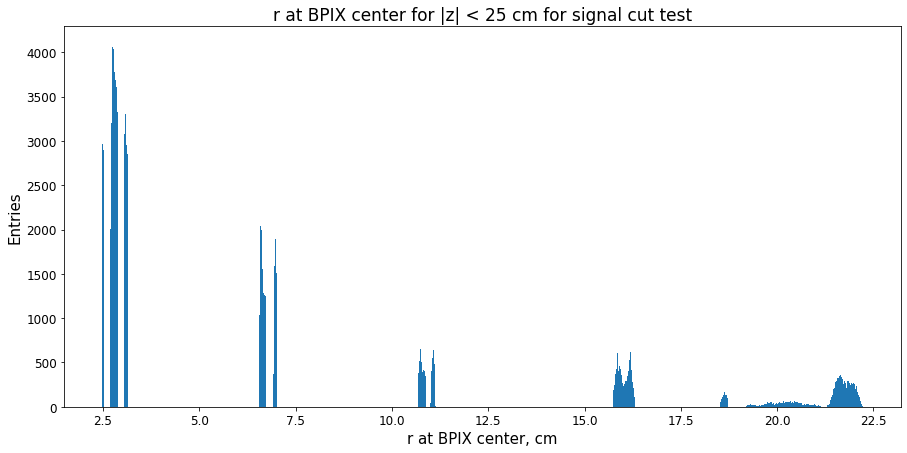

In [9]:
# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
num_bins = 2000

#n, bins, patches = ax.hist(Radius[Radius < 25], num_bins)

#correction to BPIX
#Signal
n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(np.logical_and(Radius_BPIX >2.33, Radius_BPIX <23),
                                                      np.logical_and(Y > 0, Y < 7))], num_bins)
#Signal for Beam pipe
#n, bins, patches = ax.hist(Radius_BP[np.logical_and(np.logical_and(Radius_BP >1., Radius_BP <3),
#                                                    Y ==0)], num_bins)
#Background
#n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(np.logical_and(Radius_BPIX >1., Radius_BPIX <23),
#                                                      np.logical_and(Y > 6, Y < 12))], num_bins)
#Background after L4
#n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(np.logical_and(Radius_BPIX >2.33, Radius_BPIX <23),
#                                                      Y == 11)], num_bins)

#plt.xlim(17,21)

            
#n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(Radius_BPIX >2.4, Radius_BPIX <18)], num_bins)
Xtitle = "r at BPIX center"


ax.set_xlabel(Xtitle+', cm')
ax.set_ylabel('Entries')
ax.set_title(Xtitle+' for |z| < 25 cm for signal cut test')

# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('Results/R_atBPIX_testSignalCuts.pdf')
plt.show()

## Plot variables, injected to NN <a class="anchor" id="VariablesToNN"></a>

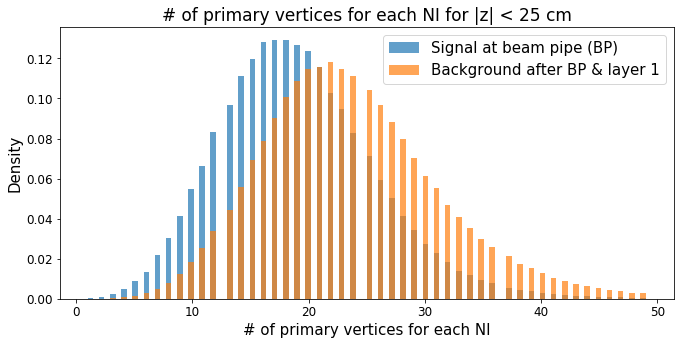

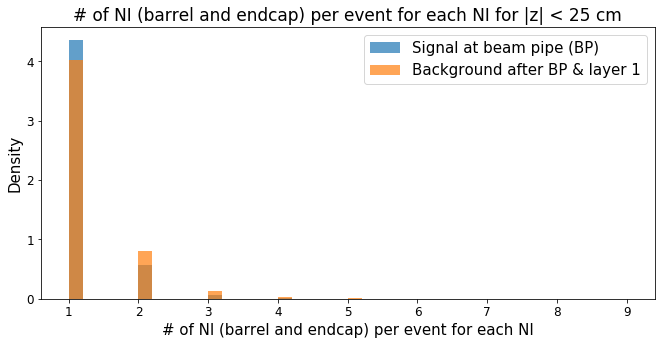

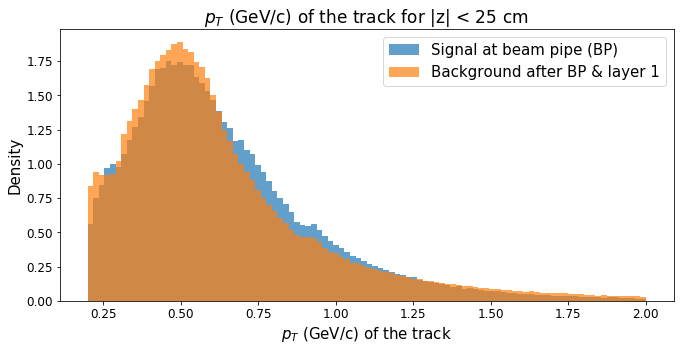

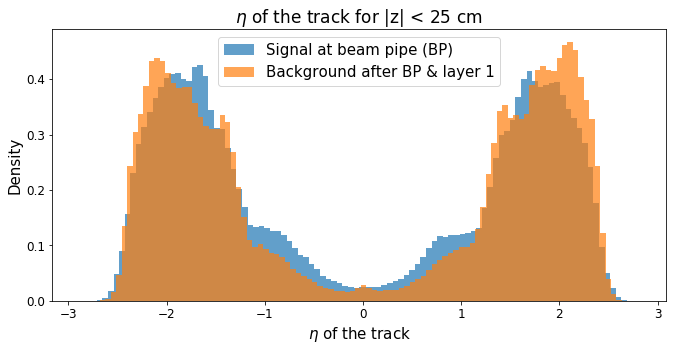

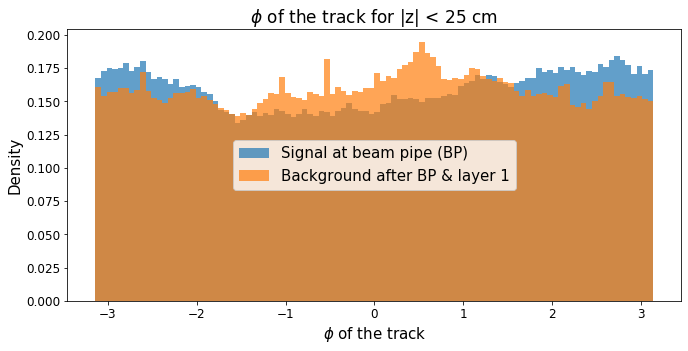

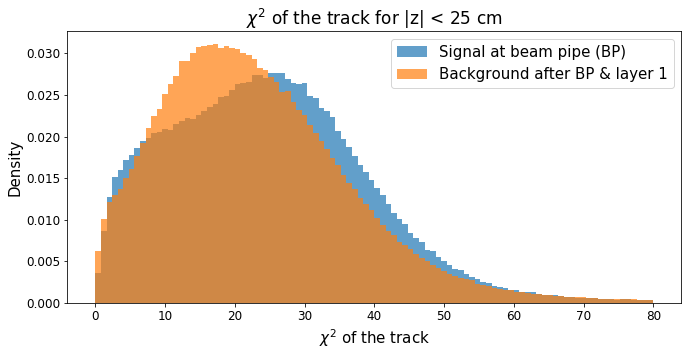

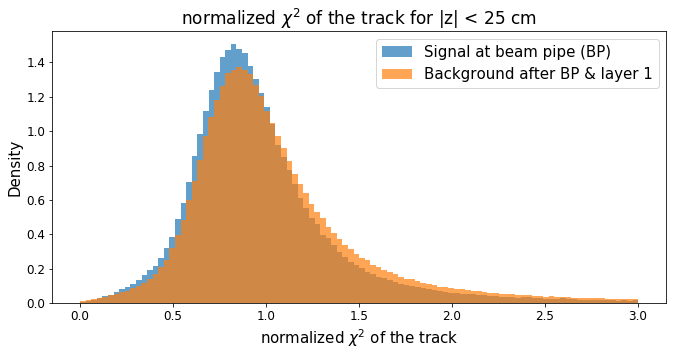

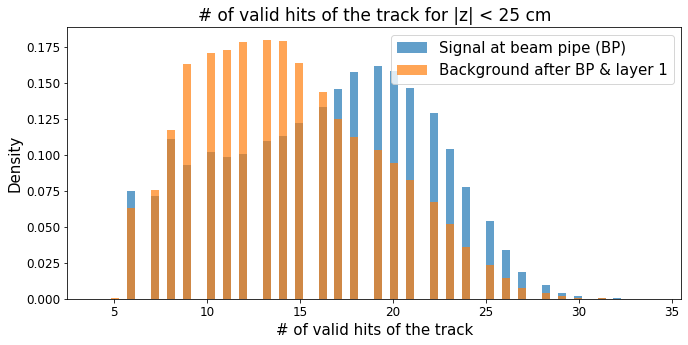

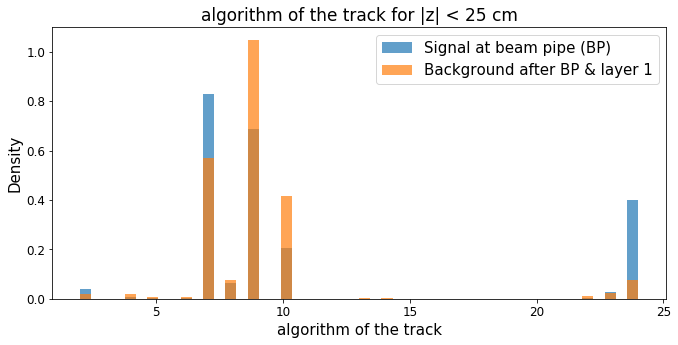

In [10]:
def PlotSvsBkg(index_var, varName, picName, num_bins, xmin, xmax, Y_S, Y_B, numPar, locPos = 'upper right'):
    fig, ax = plt.subplots(figsize=(11,5))


    # Fill 3 parameters Track 1, 2 and 3
    if numPar == 3:
        XFill = np.concatenate(([X_NN[:, index_var], X_NN[:, index_var+1], X_NN[:, index_var+2]]),axis=0)
        YFill =  np.concatenate(([Y_NN,Y_NN,Y_NN]),axis=0)
    else:
        XFill = X_NN[:, index_var]
        YFill = Y_NN
    # XFill = X_NN[:, index_var]
    # YFill = Y_NN
    # print ("shape XFill = " + str(XFill.shape))
    # print ("shape YFill = " + str(YFill.shape))


    #Signal
    n, bins, patches = ax.hist(XFill[np.logical_and(YFill == Y_S,XFill < xmax)], 
                               num_bins, density = True, alpha = 0.7)
    n, bins, patches = ax.hist(XFill[np.logical_and(YFill == Y_B,XFill < xmax)], 
                               num_bins, density = True, alpha = 0.7)


    if numPar == 3:
        Xtitle = varName + " of the track"
    else:
        Xtitle = varName + " for each NI"
    
    ax.set_xlabel(Xtitle)
    ax.set_ylabel('Density')
    ax.set_title(Xtitle +' for |z| < 25 cm')
    ax.legend(['Signal at beam pipe (BP)', 'Background after BP & layer 1'], loc=locPos)

    # Tweak spacing to prevent clipping of ylabel
    #fig.tight_layout()
    #plt.xscale('log')
    #plt.yscale('log')
    plt.savefig('Results/ControlPlots_'+picName+'.pdf')
    plt.show()
    

# Y_S and Y_B are for 7 signal + 4 bkg befor converting to 4 categories
#          index_var, varName, picName num_bins, xmin, xmax, Y_S, Y_B,    numPar locPos
# for BP and bkg BP
PlotSvsBkg(4,         "# of primary vertices","numPV",  100,      0.,   50.,    0,    8, 1)
PlotSvsBkg(5,         "# of NI (barrel and endcap) per event","numPFDV",  40,      0.,   10.,    0,    8, 1)
PlotSvsBkg(6,          "$p_T$ (GeV/c)",   "pt",   100,      0.,   2.,    0,    8, 3)
PlotSvsBkg(9,          "$\eta$", "eta",  100,      -5.,   5.,    0,    8, 3, "upper center")
PlotSvsBkg(12,         "$\phi$",   "phi",  100,      -5.,   5.,    0,    8, 3, "center")
PlotSvsBkg(15,         "$\chi^2$", "chi2",  100,      0.,   80.,    0,    8, 3)
PlotSvsBkg(18,         "normalized $\chi^2$","normalizedChi2",  100,      0.,   3.,    0,    8, 3)
PlotSvsBkg(21,         "# of valid hits","numberOfValidHits",  70,      0.,   35.,    0,    8, 3)
PlotSvsBkg(24,         "algorithm","algorithm",  50,      0.,   50.,    0,    8, 3)




In [11]:
# #histTrk_chi2.Delete()
# import ROOT
# from ROOT import TH1D, TH2D
# from root_numpy import fill_hist
# import numpy as np

# c1 = ROOT.TCanvas()

# histTrk_chi2 = TH1D('histTrk_chi2', '#chi^2 of the track for |z| < 25 cm', 81, -0.5, 80.5)
# fill_hist(histTrk_chi2, X_NN[:, index_var][np.logical_and(Y_NN == Y_S,X_NN[:, index_var] < 80)])
# fill_hist(histTrk_chi2, X_NN[:, index_var+1][np.logical_and(Y_NN == Y_S,X_NN[:, index_var+1] < 80)])
# fill_hist(histTrk_chi2, X_NN[:, index_var+2][np.logical_and(Y_NN == Y_S,X_NN[:, index_var+2] < 80)])
# histTrk_chi2.Draw()
# c1.Draw()


# Keras mode: NN with 2 hidden layers <a class="anchor" id="KerasModel"></a>

## Import libraries <a class="anchor" id="ImportKeras"></a>

In [12]:
import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.utils.np_utils import to_categorical
from keras import regularizers
# to write lost function by yourself:
import keras.backend as K

# we don't need this utils:
# to use tf_utils, you have to install it in swan terminal:
#pip install --user git+https://github.com/neuroailab/tfutils.git
# it will be installed to /eos/user/k/kropiv/.local/bin
# also see: https://github.com/swan-cern/help/blob/master/advanced/install_packages.md
#from tf_utils import convert_to_one_hot

Using TensorFlow backend.


In [13]:
!echo $PYTHONPATH
#tf.__version__
keras.__version__

/usr/local/lib/swan/extensions/:/cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/python:/cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages


'2.2.4'

## Create function for NN model with 2 hidden layers <a class="anchor" id="NNfunction"></a>

In [14]:
def NN_2Layers(input_shape, nClasses):


    sentence_indices = Input(shape=input_shape)
    
    RegMode = False
    DropoutMode = False # looks like good for big NN (not our case)
    NumHidLayers = 2 # 1 - default; 2 - non default; 3 + dropout < 0.3 - need more training data
    SigmoidTrue = False # if True then use sigmoid for output level 

    #reg_lambda = 0.5
    reg_lambda = 0.1
    Dropout_frac = 0.3 # which fraction will be dropped
    # 1st layer: Propagate X through a Dense layer with 18 units
    # this layer improve results compare to softmax directly

    #kernel_initializer='he_uniform' for relu  - bad
    #kernel_initializer='he_normal' for relu - similar to default
    
    #define shape of Layer
    #nLayer = aint((sentence_indices.shape[1] + nClasses)/2) # for python 2
    numIn = sentence_indices.shape[1].value
    nLayer = int((numIn + nClasses)/2)
    
    if NumHidLayers > 1: # from 2 hidden layers
#         nLayer = int((2*numIn + nClasses)/3)
#         nLayer = int((numIn + nClasses)/2) # default
        nLayer = int(0.4*(numIn + nClasses))# modified
#         if DropoutMode == True:
#             nLayer = int(nLayer/(1-Dropout_frac))# modified -> give more parameters to train if drop
#         nLayer = int(0.33*(numIn + nClasses))# mod1 - bad

    if RegMode == True:
        X = Dense(nLayer, use_bias=False,
                 kernel_regularizer=regularizers.l2(reg_lambda))(sentence_indices)
    else:
        X = Dense(nLayer, use_bias=False)(sentence_indices)
        
    X = BatchNormalization()(X)
    X = Activation("relu")(X)

    # Add dropout with a probability of 0.7
    if DropoutMode == True:
        X = Dropout(Dropout_frac)(X)

    # 2nd hidden layer
    if NumHidLayers > 1:
#         nLayer2 = int((2*nClasses + numIn)/3)
        nLayer2 = int((nClasses + nLayer)/2)
#         if DropoutMode == True:
#             nLayer2 = int(nLayer2/(1-Dropout_frac))
        if RegMode == True:
            X = Dense(nLayer2, use_bias=False,
                     kernel_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(nLayer2, use_bias=False)(X)

        X = BatchNormalization()(X)
        X = Activation("relu")(X)
        # Add dropout with a probability of 0.5
        if DropoutMode == True:
            X = Dropout(Dropout_frac)(X)
        
    # 3d hidden layer
    if NumHidLayers > 2:
        nLayer3 = int((nClasses + nLayer2)/2)
        if RegMode == True:
            X = Dense(nLayer3, use_bias=False,
                     kernel_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(nLayer3, use_bias=False)(X)

        X = BatchNormalization()(X)
        X = Activation("relu")(X)
        # Add dropout with a probability of 0.5
        if DropoutMode == True:
            X = Dropout(Dropout_frac)(X)

    # output layer: softmax with nClasses outputs as for Y
    if nClasses > 2 or SigmoidTrue == False:
        if RegMode == True:
            X = Dense(nClasses, activation="softmax",
                     kernel_regularizer=regularizers.l2(reg_lambda),
                     bias_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(nClasses, activation="softmax")(X)
    else:
        if RegMode == True:
            X = Dense(1, activation="sigmoid",
                     kernel_regularizer=regularizers.l2(reg_lambda),
                     bias_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(1, activation="sigmoid")(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[sentence_indices], outputs=X)

    return model


## Create final classification, by keeping numSig classes for Singnal and numBkg classes for Background 
<a class="anchor" id="FinalClassification"></a>
By default numSin = numBkg = 1

Train and Test sets are normolized by mean and std of the Train set.

Creat sets for model training:
Use only classified events (Signal or Backgound resions only, skip Unclassified resion) for Train and Validation (Test) sets.

Create sets for model testing:
Use all events (Signal, Backgound, and Unclassified regions) for Train and Test sets.

In [15]:
def DefClasses(Y_in, nSig,nBkg):
    
    nClasses = nSig + nBkg
    Y_out = Y_in + 0. # if we not add 0. then it will be rewrite original Y_in input too !!!???
    #print("in 1 Y_Train = " + str(Y_Train[0:100]))
    #select categorized events only for the Training: Y > -1
    Y_out = Y_out[Y_out > -1]
    if nSig == 4:
        Y_out[Y_out == 3] = 1 # L2
        Y_out[Y_out == 4] = 2 # L3
        Y_out[Y_out == 5] = 3 # L4
        Y_out[Y_out == 6] = 3 # OS, Rails, Tube -> merge with L4
        Y_out[Y_out > 6] = 4
    if nSig == 1: # 1 singnal and 1 background
        Y_out[Y_out < 7] = 0
        Y_out[Y_out > 6] = 1
    #print ("Error wrong number of signal classes numSig = " +str(numSig))

    # set max Y to number of classes...
    Y_out[Y_out > (nClasses-1)] = nClasses-1
    #print("in 2 Y_Train = " + str(Y_Train[0:100]))
    return Y_out

# Define number of classes 

#numSig = 7
#numBkg = 5
# interesting results for this model:
# numSig = 4
# numBkg = 1
# train any signal vs any backround
numSig = 1
numBkg = 1
#numClasses = 12 # 7 signals + 5 bkg
numClasses = numSig + numBkg # 7 singnals + 1 bkg(all bkg as one class)

#convert Y_train_NN to one-hot 

#print ("Y_Train_NN = " + str(Y_Train_NN[90:100]))
#select categorized events only for the Training: Y > -1
print("before Y_Train = " + str(Y_Train[0:100]))

# Test mode, select for Train only pileup <= 15
#Y_Train[X_Train[:,4] > 15] = -1

if numSig == 4:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Train[Y_Train == 1] = -1 # IS remove from training
    Y_Train[Y_Train == 2] = -1 # L1 remove from training
    Y_Train[Y_Train == 9] = -1 # remove L2-L3 background
    Y_Train[Y_Train == 10] = -1 # remove L3-L4 background
    Y_Train[Y_Train == 11] = -1 # remove > L4 background
if numSig == 1:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Train[Y_Train == 1] = -1 # IS remove from training
    Y_Train[Y_Train == 2] = -1 # L1 remove from training
#     Y_Train[Y_Train == 3] = -1 # L2 remove from training
#     Y_Train[Y_Train == 4] = -1 # L3 remove from training
    
Y_Train_NN = DefClasses(Y_Train, numSig, numBkg)

print("Y_Train = " + str(Y_Train[0:100]))
print("Y_Train_NN = " + str(Y_Train_NN[0:100]))

Y_Train_NN_hot = to_categorical(Y_Train_NN, num_classes = numClasses)
#print ("Y_Train_NN_hot = " + str(Y_Train_NN_hot[90:100,:]))


Xnorm_Train = X_Train[:,4:]
#normalize input data before selecting categorization: 
#Test sample should be normalized to the same value of mean and std:
mean_Norm = np.mean(Xnorm_Train, axis = 0)
std_Norm = np.std(Xnorm_Train, axis = 0)
Xnorm_Train = (Xnorm_Train - mean_Norm)/std_Norm


#select categorized events only for the Training: Y > -1
X_Train_NN = Xnorm_Train[Y_Train > -1]
print ("shape of mean_Norm = " + str(mean_Norm.shape))

batchSize = 8192
# batchSize = 1024
# batchSize = 2048
# batchSize = 4096
#batchSize = 512 # worth to train 300 epochs, after it is stable for 1 hidden layer
# NumTrain_NN = (np.floor(X_Train_NN.shape[0]/batchSize)).astype(int)*batchSize
# # cut last bach that is small then batchSize
# X_Train_NN = X_Train_NN[:NumTrain_NN,:]
# Y_Train_NN_hot = Y_Train_NN_hot[:NumTrain_NN]
print("shape of X_Train_NN to be injected to NN = " + str(X_Train_NN.shape))

# normilize Test set and Train one
Xnorm_Test = X_Test[:,4:27]
#normalize input data: Test sample should be normalized to the mean and std of Test:
Xnorm_Test = (Xnorm_Test - mean_Norm)/std_Norm

if numSig == 4:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Test[Y_Test == 1] = -1 # IS remove from training
    Y_Test[Y_Test == 2] = -1 # L1 remove from training
    Y_Test[Y_Test == 9] = -1 # remove L2-L3 background
    Y_Test[Y_Test == 10] = -1 # remove L3-L4 background
    Y_Test[Y_Test == 11] = -1 # remove > L4 background
if numSig == 1:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Test[Y_Test == 1] = -1 # IS remove from training
    Y_Test[Y_Test == 2] = -1 # L1 remove from training
#     Y_Test[Y_Test == 3] = -1 # L2 remove from training
#     Y_Test[Y_Test == 4] = -1 # L3 remove from training

    
# select Test for validation where Y > -1
Y_Test_val = DefClasses(Y_Test, numSig, numBkg)
Y_Test_val_hot = to_categorical(Y_Test_val, num_classes = numClasses)
Xnorm_Test_val = Xnorm_Test[Y_Test > -1]

before Y_Train = [ 8. 10.  7.  8.  2.  8.  0.  0.  3.  6.  8. -1.  8.  0. -1.  8.  8. -1.
  7. -1.  3.  8.  9. -1. -1.  2.  8. -1. -1.  8.  3. -1.  8.  9.  9.  8.
 -1. -1.  0. -1.  0. -1. -1. -1.  0. -1. -1.  8. -1. -1.  8.  8.  8.  8.
  9. -1.  8. -1. -1. 11. -1.  7.  8.  8.  2.  8.  9.  2. -1. -1.  0. -1.
  6.  3.  8. -1.  8.  2.  9. -1.  8. -1. -1. -1.  8.  2.  9. -1. -1. 10.
 -1.  9.  7.  9. -1.  5.  9.  9.  7. -1.]
Y_Train = [ 8. 10.  7.  8. -1.  8.  0.  0.  3.  6.  8. -1.  8.  0. -1.  8.  8. -1.
  7. -1.  3.  8.  9. -1. -1. -1.  8. -1. -1.  8.  3. -1.  8.  9.  9.  8.
 -1. -1.  0. -1.  0. -1. -1. -1.  0. -1. -1.  8. -1. -1.  8.  8.  8.  8.
  9. -1.  8. -1. -1. 11. -1.  7.  8.  8. -1.  8.  9. -1. -1. -1.  0. -1.
  6.  3.  8. -1.  8. -1.  9. -1.  8. -1. -1. -1.  8. -1.  9. -1. -1. 10.
 -1.  9.  7.  9. -1.  5.  9.  9.  7. -1.]
Y_Train_NN = [1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.


## Creat NN model structure and compile it <a class="anchor" id="ModelCompile"></a>

Define loss funtion, and monitoring parameters as precision, recall, and f1 Score.

In [17]:
# f1 and f1_loss are taken from here: https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# def f1_loss(y_true, y_pred):
    
#     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
#     tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
#     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

#     p = tp / (tp + fp + K.epsilon())
#     r = tp / (tp + fn + K.epsilon())

#     f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
#     return 1 - K.mean(f1)

# in principle the same
def f1_score_2(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

#### This fix problem for 2 classes of the same value for all metrics, didn't check if it works for n classes
# taken and modified for numClasses from here:    https://github.com/keras-team/keras/issues/5400

def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
#         y_pred = y_pred[:,1:2]
#         y_true = y_true[:,1:2]
        y_pred = y_pred[:,0:numClasses-1]
        y_true = y_true[:,0:numClasses-1]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_loss(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
#    f1 = f1*r # correct to f1_loss more weithg for recall
##    f1 = f1*K.sqrt(r) # correct to f1_loss more weithg for recall
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

### end for test


#reset layers counting
K.clear_session()

model = NN_2Layers((X_Train_NN.shape[1],),numClasses)

# problem with same outout form metrisc discussed here: https://github.com/keras-team/keras/issues/5400
# looks like if you have 2 classes and use sigmoid instead of softmax doesn't help...
# check_units (see above) hepls to fix problem for 2 classes, didn't check if it works for n classes

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score, precision, recall])

# sgd is good for shalow NN (our case), adam is good for deep NN
sgd      = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# default beta_1 = 0.9
adamCorr = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False) # av. by last 100

# model.compile(loss=f1_loss, optimizer='Nadam', metrics=['accuracy', f1_score, precision, recall])
model.compile(loss=f1_loss, optimizer=adamCorr, metrics=['accuracy', f1_score, precision, recall])
# model.compile(loss=f1_loss, optimizer='adam', metrics=['accuracy', f1_score, precision, recall])
# model.compile(loss=f1_loss, optimizer=sgd, metrics=['accuracy', f1_score, precision, recall])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                230       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 60        
_________________________________________________________________
batch_normalization_2 (Batch (None, 6)                 24        
_________________________________________________________________
activation_2 (Activation)    (None, 6)                 0         
__________

## NN model training <a class="anchor" id="ModelTraining"></a>
Skip this section if you are going to upload existing model.

Use only classified events (Signal or Backgound resions only, skip Unclassified resion) for Train set and Validation (Test) set during model model.

In [18]:
def generate_sample_weights(training_data, class_weight_dictionary): 
    sample_weights = [class_weight_dictionary[np.where(one_hot_row==1)[0][0]] for one_hot_row in training_data]
    return np.asarray(sample_weights) # correct on dropout


# not bad:
#class_weight = {0: 2., 1: 2., 2: 3., 3: 3., 4: 4., 5: 4., 6:2., 
#               7:1., 8: 1., 9: 1., 10: 1., 11: 1.}

# class_weight = {0: 4., 1: 3., 2: 3., 3: 10., 4: 4., 5: 4., 6:2., 
#                 7:1., 8: 1., 9: 1., 10: 1., 11: 1.}
# class_weight = {0: 1., 1: 1., 2: 1., 3: 1., 4: 1., 5: 1., 6:1., 
#                 7:1., 8: 1., 9: 1., 10: 1., 11: 1.}

if numSig == 7:
    class_weight = {0: 10., 1: 0.1, 2: 0.1, 3: 10., 4: 5., 5: 5., 6:4., 
                   7:1., 8: 1., 9: 1., 10: 1., 11: 1.}
if numSig == 4:
    #               BP      L2     L3    L4, OS, Rails, Tube     BKG
    # class_weight = {0: 5., 1: 0.1, 2: 0.1, 3: 2.,                  4: 1.} # for ...Epoch1000 file
#     class_weight = {0: 5., 1: 10., 2: 10., 3: 2.,                  4: 1.} # for ...Epoch1000_L2L3
#     class_weight = {0: 4., 1: 7., 2: 10., 3: 2.,                  4: 1.} # for ...Epoch1000_L2L3 tune
#     class_weight = {0: 4., 1: 8., 2: 10., 3: 2.,                  4: 1.} # for ...Epoch1000_L2L3 tuneX
    class_weight = {0: 4.2, 1: 9., 2: 12., 3: 2.,                  4: 1.} # for ...Epoch1000_L2L3 tune final
#     class_weight = {0: 3.9, 1: 10., 2: 14., 3: 2.,                  4: 1.} # for ...Epoch1000_L2L3 NN 3 layers
#     class_weight = {0: 2., 1: 7., 2: 10., 3: 2.,                  4: 1.} # for ...low pile up
#     class_weight = {0: 5., 1: 5., 2: 5., 3: 5.,                  4: 1.}
    
#train and keep history about model:
# history = model.fit(X_Train_NN, Y_Train_NN_hot, epochs = 1000, 
#                     validation_data=(Xnorm_Test_val, Y_Test_val_hot,
#                                      generate_sample_weights(Y_Test_val_hot, class_weight)),
#                     batch_size = 8192, shuffle=True, class_weight=class_weight)

# no weights for customized models:
# usually you need 300-500 epochs to train model well, but we set it to 50 for fast results
history = model.fit(X_Train_NN, Y_Train_NN_hot, epochs = 50, validation_data=(Xnorm_Test_val, Y_Test_val_hot),
                    batch_size = batchSize, shuffle=True)

Train on 415289 samples, validate on 414198 samples
Epoch 1/50
415289/415289 [==============================] - 2s 4us/step - loss: 0.5295 - acc: 0.3599 - f1_score: 0.4840 - precision: 0.3237 - recall: 0.9630 - val_loss: 0.4936 - val_acc: 0.4960 - val_f1_score: 0.5242 - val_precision: 0.3712 - val_recall: 0.8922
Epoch 2/50
415289/415289 [==============================] - 1s 2us/step - loss: 0.4707 - acc: 0.5760 - f1_score: 0.5504 - precision: 0.4139 - recall: 0.8301 - val_loss: 0.4445 - val_acc: 0.6648 - val_f1_score: 0.5816 - val_precision: 0.4755 - val_recall: 0.7488
Epoch 3/50
415289/415289 [==============================] - 1s 2us/step - loss: 0.4238 - acc: 0.6881 - f1_score: 0.5928 - precision: 0.5000 - recall: 0.7302 - val_loss: 0.4144 - val_acc: 0.6926 - val_f1_score: 0.5990 - val_precision: 0.5042 - val_recall: 0.7379
Epoch 4/50
415289/415289 [==============================] - 1s 2us/step - loss: 0.4033 - acc: 0.7152 - f1_score: 0.6052 - precision: 0.5319 - recall: 0.7026 - val

Epoch 32/50
415289/415289 [==============================] - 1s 2us/step - loss: 0.3627 - acc: 0.7590 - f1_score: 0.6384 - precision: 0.5983 - recall: 0.6845 - val_loss: 0.3634 - val_acc: 0.7544 - val_f1_score: 0.6378 - val_precision: 0.5895 - val_recall: 0.6947
Epoch 33/50
415289/415289 [==============================] - 1s 2us/step - loss: 0.3615 - acc: 0.7590 - f1_score: 0.6397 - precision: 0.5977 - recall: 0.6882 - val_loss: 0.3629 - val_acc: 0.7501 - val_f1_score: 0.6384 - val_precision: 0.5807 - val_recall: 0.7089
Epoch 34/50
415289/415289 [==============================] - 1s 2us/step - loss: 0.3597 - acc: 0.7613 - f1_score: 0.6416 - precision: 0.6018 - recall: 0.6873 - val_loss: 0.3661 - val_acc: 0.7461 - val_f1_score: 0.6347 - val_precision: 0.5747 - val_recall: 0.7090
Epoch 35/50
415289/415289 [==============================] - 1s 3us/step - loss: 0.3593 - acc: 0.7621 - f1_score: 0.6419 - precision: 0.6033 - recall: 0.6859 - val_loss: 0.3618 - val_acc: 0.7500 - val_f1_score: 

## Save/Load NN model to/from file <a class="anchor" id="Save-Load-Model"></a>

In [19]:
import json
from keras.models import load_model

SaveMode = False
LoadMode = True

# lr = 0.1, too large, not train model, even 0.02 is bad too
# two default models
ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1loss_batchSize8192_adamLr0p005_Epoch500'
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize8192_adamLr0p005_Epoch500'



# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize8192_adamLr0p005_Epoch300'

#ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1loss_batchSize8192_adamLr0p005_Epoch200'
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1loss_batchSize4096_adamLr0p005_Epoch200' # overtrained from 150 epochs

# some tests models:
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize1024_adamLr0p005_Epoch200'
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1loss_batchSize1024_adamLr0p005_Epoch200n' # good
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1loss_Drop_0p3_batchSize1024_adamLr0p005_Epoch200'
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1loss_batchSize1024_adamLr0p005_Epoch200'
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize1024_adamLr0p005_heNormal_Epoch200' # simial to default init
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize1024_adamLr0p005_heUniform_Epoch200' # bad
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize1024_adamLr0p005_Epoch500' # not really good ... new initialization, 200 better

# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize1024_adamLr0p01_Epoch200' # even better
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize1024_adamLr0p002_Epoch200' #super good cleaning
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize1024_adam0p8_Epoch200'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize1024_adam0p99_Epoch200'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize1024_Nadam_Epoch200'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize1024_Epoch500' # different init and worse results then for 200 Epoch
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize1024_Epoch200' # loss = 1 - f1*recall, very good cleaning (factor by 2 and no signal cut)

# Train and Test sample were splitted randomly each time --> we don't know which events were in Train sample...
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize4096_Epoch200'
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1loss_batchSize2048_Epoch300'
#ModelName = 'model_Sig1_noIS_noL123_Bkg1_2HLmod_f1loss_batchSize8192_Epoch300' # it works ok too
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1loss_batchSize8192_Epoch300'
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod1_f1loss_batchSize1024_Epoch300' # not very good 
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1loss_batchSize1024_Epoch300' # good
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HL_f1loss_batchSize1024_sgd_Epoch300'
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HL_f1lossCorr_batchSize1024_Epoch500' # loss = 1 - f1*sqrt(recall),
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HL_f1loss_batchSize1024_Epoch1000'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_f1loss_batchSize1024_Epoch1000' # good, HotCut = 10e-6 give similar result to 1-f1*recall
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HL_f1loss_batchSize1024_Epoch200' # loss = 1 - f1*recall, reduce bkg by factor 2, but don't touch any signal
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_3HL_f1loss_lambda_0p1_batchSize1024_Epoch300'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_3HL_f1loss_Drop_0p1_batchSize1024_Epoch300'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_3HL_f1loss_Drop_0p3_batchSize1024_Epoch300'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_3HL_f1loss_lambda_0p1_Drop_0p3_batchSize1024_Epoch300'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_3HL_f1loss_batchSize1024_Epoch300'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_f1loss_batchSize512_sgd_Epoch1000'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_f1loss_batchSize2048_sgd_Epoch1000'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_f1loss_batchSize1024_sgd_Epoch1000'

#ModelName = 'model_Sig1_noIS_noL1_Bkg1_f1loss_Epoch5000'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_f1loss_Epoch1000'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HL_f1loss_Epoch1000'
#ModelName = 'model_Sig1_noIS_noL123_Bkg1_Epoch1000_f1loss'
#ModelName = 'model_Sig1_noIS_noL1_Bkg1_Epoch1000_f1loss'
#ModelName = 'model_Sig1_Bkg1_Epoch5000_f1loss'
#ModelName = 'model_Sig1_Bkg1_Epoch1000_f1loss'
# ModelName = 'model_Sig4_Bkg1_Epoch1000_f1loss'
#ModelName = 'model_Sig4_Bkg1_Epoch10000_L2L3_lambda_0p1_f1loss'
# ModelName = 'model_Sig4_Bkg1_Epoch1000_L2L3_lambda_0p1_f1loss'
#ModelName = 'model_Sig4_Bkg1_Epoch1000_L2L3_lambda_0p1_tune'
#ModelName = 'model_Sig4_Bkg1_Epoch1000_L2L3_lambda_0p1_Layers_3'




FileModelName = 'TrainedModels/' + ModelName

if SaveMode:
    #save model:
    model.save(FileModelName + '.h5')
    # save history:
    with open(FileModelName + '.json', 'w') as f:
        json.dump(history.history, f)

    # plot model only in SaveMode
    # python 3.4 and about only for redirect_stdout
    from contextlib import redirect_stdout
    NameSum = 'Results/' + ModelName + '_summary.txt'
    with open(NameSum, 'w') as f:
        with redirect_stdout(f):
            model.summary()
    # plot model:
    from keras.utils import plot_model
    plot_model(model, to_file = 'Results/' + ModelName + '.pdf',show_shapes = True)

# del model
# del history

FileLoadName = 'TrainedModels/' + ModelName
# very good 50 %
#FileLoadName = '/eos/user/k/kropiv/root-files/NI/model_Sig4_BKG1_Epoch1000_L2L3_lambda_0p1_tune'
# very good 50% bkg is regected between L1-L2
#FileLoadName = '/eos/user/k/kropiv/root-files/NI/model_Sig4_BKG1_Epoch1000_L2L3_lambda_0p1_pileup_15'
#FileLoadName = '/eos/user/k/kropiv/root-files/NI/model_Sig4_BKG1_Epoch1000_L2L3_lambda_0p1'
#bad model: all as signal
#FileLoadName = '/eos/user/k/kropiv/root-files/NI/model_Sig4_BKG1_Epoch1000_L2L3_lambda_10p0'
#ok model
#FileLoadName = '/eos/user/k/kropiv/root-files/NI/model_Sig4_BKG1_Epoch1000_L2L3_lambda_1p0'
#reg_lambda = 0.5: ok model
#FileLoadName = '/eos/user/k/kropiv/root-files/NI/model_Sig4_BKG1_Epoch1000'
#FileLoadName = '/eos/user/k/kropiv/root-files/NI/model_Sig4_BKG1_Epoch1000_L2L3'

# returns a compiled and trained model
# if loss == f1_loss
f1lossMode = "f1loss" in ModelName
if LoadMode : 
    if f1lossMode:
        model_X = load_model(FileLoadName + '.h5', 
                             custom_objects={'f1_loss':f1_loss, 'f1_score':f1_score, 
                                             'precision':precision, 'recall':recall})
        history_X = json.load(open(FileLoadName + '.json', 'r'))
    else:
        model_X = load_model(FileLoadName + '.h5', custom_objects={'f1_score':f1_score, 'precision':precision, 'recall':recall})
        history_X = json.load(open(FileLoadName + '.json', 'r'))

if LoadMode == False:
    model_X = model
    history_X = history.history

## Monitor performance during training <a class="anchor" id="MonitorTraining"></a>

Monitor accuracy, precision, recall, f1 Score, and loss function.

dict_keys(['val_loss', 'val_acc', 'val_f1_score', 'val_precision', 'val_recall', 'loss', 'acc', 'f1_score', 'precision', 'recall'])
shape acc = (500,)


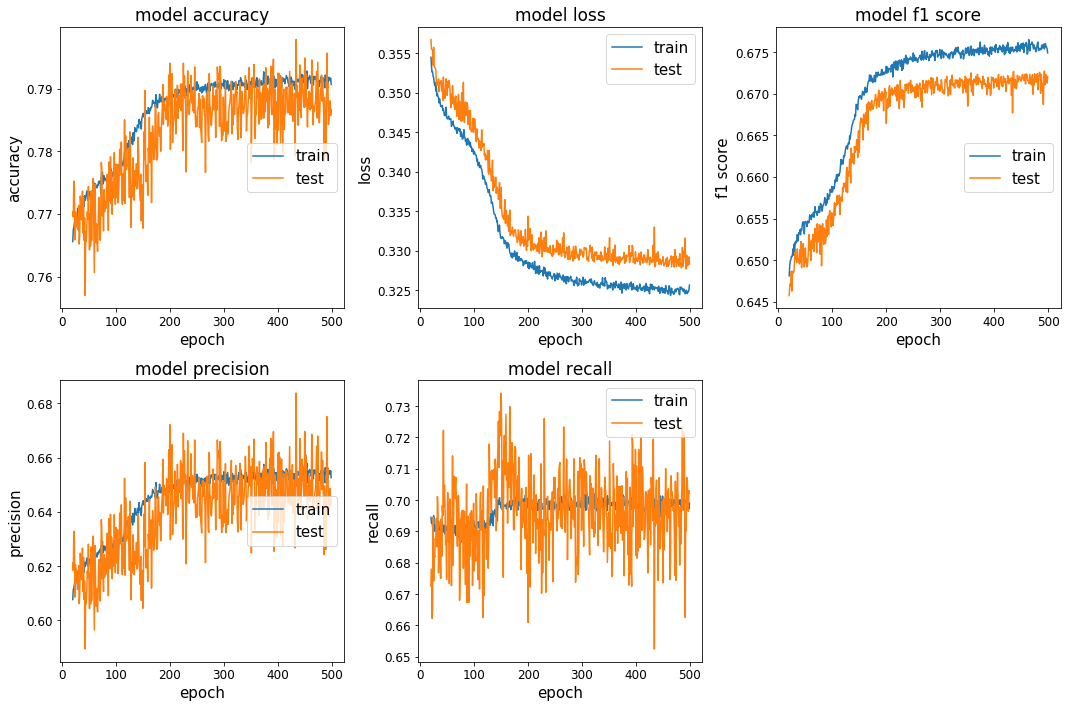

In [20]:
#plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize = 15)
plt.rc('axes', titlesize= 17)
plt.rc('font', size=12) 
plt.rc('legend', fontsize=15) 
# list all data in history
# print(history.history.keys())
print(history_X.keys())
# summarize history for accuracy

# set epoch range
par_acc = np.array(history_X['acc'])
print("shape acc = " + str(par_acc.shape))
par_val_acc = np.array(history_X['val_acc'])
par_loss = np.array(history_X['loss'])
par_val_loss = np.array(history_X['val_loss'])
par_f1_score = np.array(history_X['f1_score'])
par_val_f1_score = np.array(history_X['val_f1_score'])
par_precision = np.array(history_X['precision'])
par_val_precision = np.array(history_X['val_precision'])
par_recall = np.array(history_X['recall'])
par_val_recall = np.array(history_X['val_recall'])

nEpoch_min = 20
nEpoch_max = par_acc.shape[0]
xc         = range(nEpoch_min,nEpoch_max)


# need to be 2D with shape (2,2) if (2,2) plots 
fig, ((a_acc, a_loss, a_f1), (a_prec, a_recall, a_null)) = plt.subplots(2,3,  figsize=(15,10))
fig.delaxes(a_null)
#fig.delaxes(a_f1)
    
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
a_acc.plot(xc,par_acc[nEpoch_min:nEpoch_max])
a_acc.plot(xc,par_val_acc[nEpoch_min:nEpoch_max])
a_acc.set_title('model accuracy')
a_acc.set_ylabel('accuracy')
a_acc.set_xlabel('epoch')
a_acc.legend(['train', 'test'], loc='center right')
#a_acc.set_xlim(nEpoch_min,nEpoch_max)

# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
a_loss.plot(xc,par_loss[nEpoch_min:nEpoch_max])
a_loss.plot(xc,par_val_loss[nEpoch_min:nEpoch_max])
a_loss.set_title('model loss')
a_loss.set_ylabel('loss')
a_loss.set_xlabel('epoch')
a_loss.legend(['train', 'test'], loc='upper right')

a_f1.plot(xc,par_f1_score[nEpoch_min:nEpoch_max])
a_f1.plot(xc,par_val_f1_score[nEpoch_min:nEpoch_max])
a_f1.set_title('model f1 score')
a_f1.set_ylabel('f1 score')
a_f1.set_xlabel('epoch')
a_f1.legend(['train', 'test'], loc='center right')

a_prec.plot(xc,par_precision[nEpoch_min:nEpoch_max])
a_prec.plot(xc,par_val_precision[nEpoch_min:nEpoch_max])
a_prec.set_title('model precision')
a_prec.set_ylabel('precision')
a_prec.set_xlabel('epoch')
a_prec.legend(['train', 'test'], loc='center right')

a_recall.plot(xc,par_recall[nEpoch_min:nEpoch_max])
a_recall.plot(xc,par_val_recall[nEpoch_min:nEpoch_max])
a_recall.set_title('model recall')
a_recall.set_ylabel('recall')
a_recall.set_xlabel('epoch')
a_recall.legend(['train', 'test'], loc='upper right')

fig.tight_layout()
#fig.tight_layout(pad=1.0)
plt.savefig('Results/' + ModelName + '_history.pdf')
plt.show()

## Model Results <a class="anchor" id="ModelResults"></a>
Use all events (Signal, Backgound, and Unclassified regions) for Train and Test sets.

### Predict Y for Train and Test sets <a class="anchor" id="PredictY"></a>
Prediction is done for all regions for the data set, inlcuding unclassified region.

In [21]:
Y_hot_Test_pred = model_X.predict(Xnorm_Test)
Y_hot_Train_pred = model_X.predict(Xnorm_Train)

# Y_hot_Test_pred = model_X.predict_proba(Xnorm_Test)
# Y_hot_Train_pred = model_X.predict_proba(Xnorm_Train)

### Plot Y prediction of Test set for n-th class <a class="anchor" id="PlotY"></a>

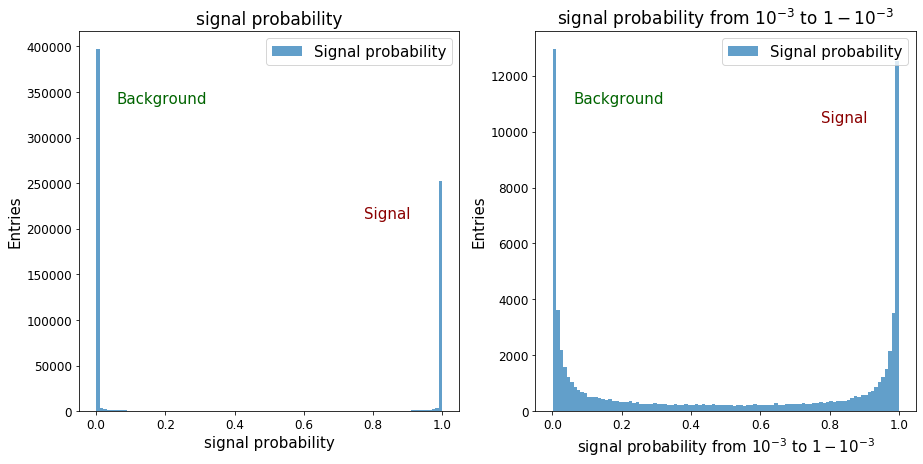

In [22]:
# Signal class:
nclass = 0

Y_Test_pred_nclass = Y_hot_Test_pred[:,nclass]
fig, (ax,bx) = plt.subplots(1,2, figsize=(15,7))
num_bins = 100
transperance = 0.7

n, bins, patches = ax.hist(Y_Test_pred_nclass, 
                            num_bins, range =[0,1], alpha = transperance)
n, bins, patches = bx.hist(Y_Test_pred_nclass, 
                            num_bins, range =[1.0e-3,1-1.0e-3], alpha = transperance)
Xtitle = 'signal probability'
Ytitle = 'Entries'
ax.set_xlabel(Xtitle)
ax.set_ylabel(Ytitle)
ax.set_title(Xtitle)
ax.legend(['Signal probability'], loc='upper right')
ax.text(0.1, 0.8, "Background",
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes, color='darkgreen', fontsize=15)
ax.text(0.75, 0.5, "Signal",
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes, color='darkred', fontsize=15)
bx.text(0.1, 0.8, "Background",
        verticalalignment='bottom', horizontalalignment='left',
        transform=bx.transAxes, color='darkgreen', fontsize=15)
bx.text(0.75, 0.75, "Signal",
        verticalalignment='bottom', horizontalalignment='left',
        transform=bx.transAxes, color='darkred', fontsize=15)

Xtitle = 'signal probability from $10^{-3}$ to $1-10^{-3}$'
bx.set_xlabel(Xtitle)
bx.set_ylabel(Ytitle)
bx.set_title(Xtitle)
bx.legend(['Signal probability'], loc='upper right')

#plt.xscale('log')

plt.savefig('Results/' + ModelName +'_SignalProbability.pdf')
plt.show()

### Set threshold for Signal-Background seperation <a class="anchor" id="SetYthreshold"></a>

Default threshold is cutHot = 0.5 is recommended to use.

In [23]:
#print("Y_hot_Test_pred = " +str(Y_hot_Test_pred[1:20]))

if numSig == 1:
    #cutHot = 1-1.0e-6
    #cutHot = 1.0e-6
    #cutHot = 1.0e-9 # almost no signal in bkg
    cutHot = 0.5 # as argmax does
    Y_Test_pred = Y_hot_Test_pred[:,0] # signal probability
    Y_Test_pred = 1.*np.invert(Y_Test_pred > cutHot)
    Y_Train_pred = Y_hot_Train_pred[:,0] # signal probability
    Y_Train_pred = 1.*np.invert(Y_Train_pred > cutHot)
else:
    Y_Test_pred = np.argmax(Y_hot_Test_pred, axis = 1)
    Y_Train_pred = np.argmax(Y_hot_Train_pred, axis = 1)

print("shape of Y_Test_pred = " + str(Y_Test_pred.shape))

# argsort_Y_hot_Test = np.argsort(Y_hot_Test_pred, axis = 1)
# argsort_Y_hot_Train = np.argsort(Y_hot_Train_pred, axis = 1)

#print("Y_Test_pred = " +str(Y_Test_pred[200:300]))
# print("Y_Test = " +str(Y_Test[200:300]))

#print("Y_Train_pred = " +str(Y_Train_pred[200:300]))
# print("Y_Train = " +str(Y_Train[200:300]))
# print("Y_Train_NN_hot = " +str(Y_Train_NN_hot[200:210,:]))
# print("XX = " +str(XX[200:210,:]))
# print("mean_Norm = " +str(mean_Norm))

shape of Y_Test_pred = (698691,)


### Plot Train and Test prediction for Signal-Background seperation as function of  BPIX radius <a class="anchor" id="PlotPredictedResultsR"></a>

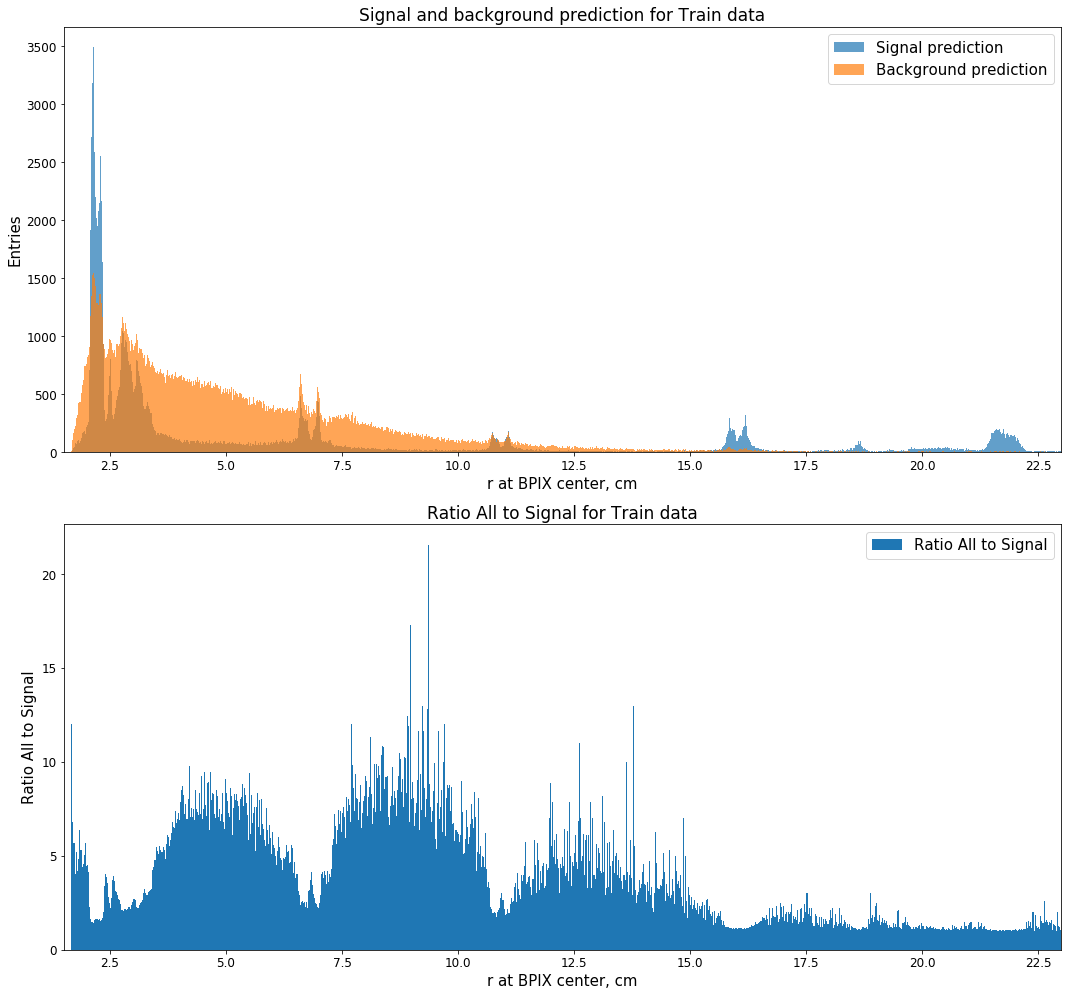

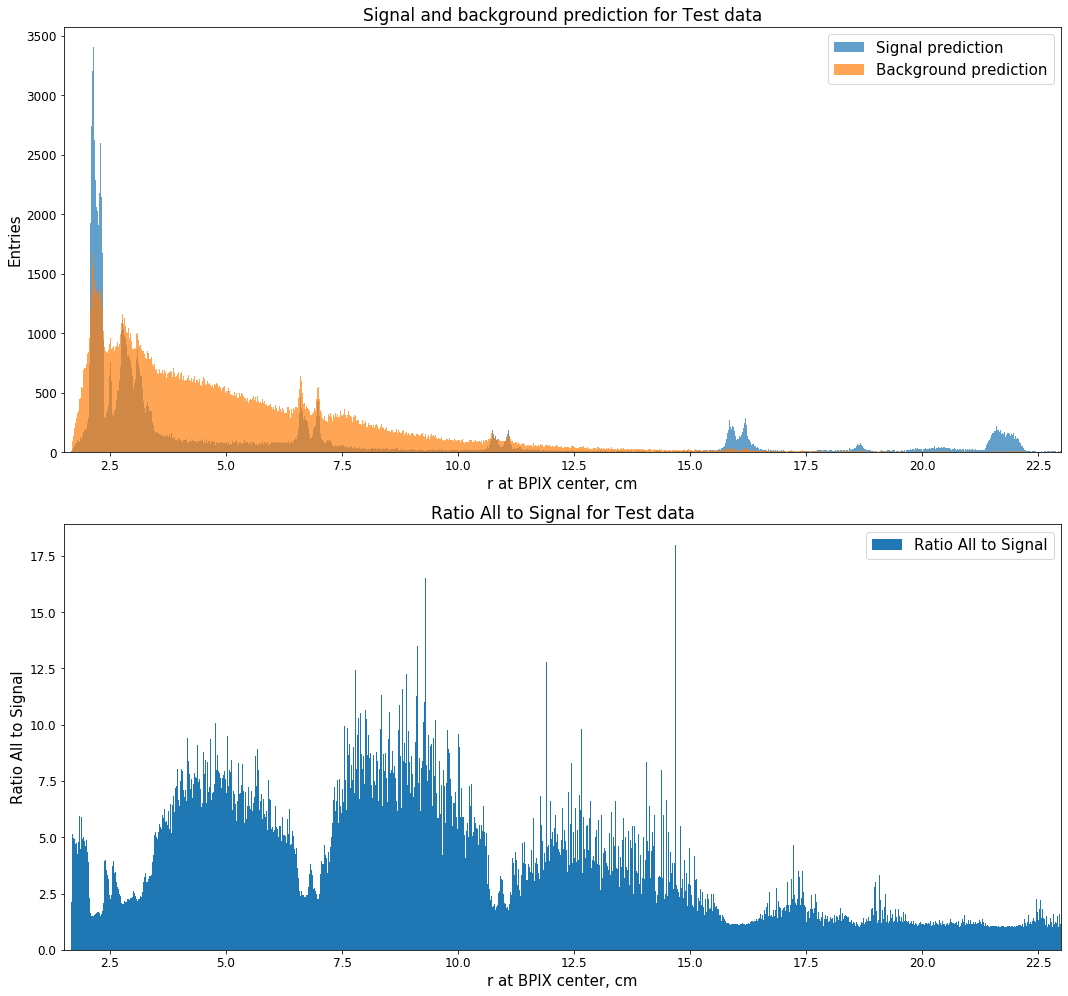

In [24]:
def PlotR_pred(Rad, Y_pred, Rmin, Rmax, Tit, nb):
    # using the variable ax for single a Axes
    fig, (ax,bx) = plt.subplots(2,1, figsize=(15,14))
    num_bins = nb
    transperance = 0.7
    

    #Signal
#     n, bins, patches = ax.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                        np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses))], num_bins)


    n_Sig, bins, patches = ax.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
                                                  np.logical_and(Y_pred > -1, Y_pred < numSig))], 
                               num_bins, range =[Rmin,Rmax], alpha = transperance)
    n_Bkg, bins, patches = ax.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
                                                       np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses))], 
                               num_bins, range =[Rmin,Rmax], alpha = transperance)
                  
#     n, bins, patches = ax.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                         np.logical_and(Y_pred > -1, Y_pred < numSig))], 
#                                num_bins, alpha = transperance)
#     n, bins, patches = ax.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                        np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses))], 
#                                num_bins, alpha = transperance)
    
#     n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                       np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses))], num_bins)

#     n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                                  np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses)),
#                                                   X_Test[:,4] > 20)], num_bins)
#     n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                                  np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses)),
#                                                   X_Test[:,4] < 20)], num_bins)

#     n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                                  np.logical_and(Y_pred > -1, Y_pred < numSig)),
#                                                   X_Test[:,4] < 20)], num_bins)
#     n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                                  np.logical_and(Y_pred > -1, Y_pred < numSig)),
#                                                   X_Test[:,4] > 20)], num_bins)

#    plt.xlim(4,10)
#     n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),X_Test[:,4] < 15)], num_bins, density = 1)
#     n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),X_Test[:,4] > 15)], num_bins, density = 1)
#     #n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),X_Test[:,4] < 15)], num_bins, density = 1)
    

#     n_AllToSig, bins, patches = bx.hist(Rad[np.logical_and(Rad > Rmin, Rad < Rmax)],
#                                num_bins, range =[Rmin,Rmax], alpha = transperance)

    # ratio of All to Signal give 0 is divide by 0:
    weights_Divide = np.divide((n_Sig+n_Bkg), n_Sig, out=np.zeros_like((n_Sig+n_Bkg)), where=n_Sig!=0)
#     weights_Divide = np.divide(n_Bkg, n_Sig, out=np.zeros_like(n_Bkg), where=n_Sig!=0)
    
    n_AllToSig, bins, patches = bx.hist(bins[:-1], bins, weights=weights_Divide)
#     n_AllToSig, bins, patches = bx.hist(bins[:-1], bins)
    
#     print("n_Sig = " + str(n_Sig[40:100]))
#     print("n_Bkg = " + str(n_Bkg[40:100]))
#     print("weights_Divide = " + str(weights_Divide[40:100]))
#     print ("shape of n_Sig = " +str(n_Sig.shape))
#     print ("shampe of n_AllToSig = "+ str(n_AllToSig.shape))
    
#     if numSig > 3:
#         n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                        Y_pred == 1)], num_bins, alpha = transperance)    
#         n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                        Y_pred == 2)], num_bins, alpha = transperance)
#         n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                        Y_pred == 3)], num_bins, alpha = transperance)
#     if numSig == 1:
#         n, bins, patches = bx.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                        Y_pred == 0)], num_bins, alpha = transperance)

    # calculate ratio of Background callified events to Signal classified events
    
        
    Xtitle = 'r at BPIX center, cm'
    Ytitle = 'Entries'
    ax.set_xlabel(Xtitle)
    ax.set_ylabel(Ytitle)
    ax.set_title("Signal and background prediction for "+ Tit + " data")
    ax.legend(['Signal prediction', 'Background prediction'], loc='upper right')
    ax.set_xlim(Rmin,Rmax)
    
#     bx.set_xlabel(Xtitle)
#     bx.set_ylabel(Ytitle)
#     if numSig > 3:        
#         bx.set_title("Signal prediction for "+ Tit + " data by category: L2, L3 and L4")
#         bx.legend(['L2 prediction', 'L3 prediction', 'L4 prediction'], loc='upper right')
#     else:
#         bx.set_title("Signal prediction for "+ Tit + " data")
#         bx.legend(['Signal prediction'], loc='upper right')

    bx.set_xlabel(Xtitle)
    bx.set_ylabel("Ratio All to Signal")
    bx.set_title("Ratio All to Signal for "+ Tit + " data")
    bx.legend(['Ratio All to Signal'], loc='upper right')
    bx.set_xlim(Rmin,Rmax)
    
    #plt.legend(['Signal prediction', 'Background prediction'], loc='upper right')
    #plt.xscale('log')
    #plt.yscale('log')
    fig.tight_layout()

    plt.savefig('Results/' + ModelName + '_' + Tit + '_Pred.pdf')
    plt.show()


# the histogram of the data
#Radius_Train = np.sqrt(np.square(data[:,1])+np.square(data[:,2]))
Radius_BP_Train = np.sqrt(np.square(X_Train[:,1]-0.171)+np.square(X_Train[:,2]+0.176))
Radius_BP_Test = np.sqrt(np.square(X_Test[:,1]-0.171)+np.square(X_Test[:,2]+0.176))
Radius_BPIX_Train = np.sqrt(np.square(X_Train[:,1]-0.086)+np.square(X_Train[:,2]+0.102))
Radius_BPIX_Test = np.sqrt(np.square(X_Test[:,1]-0.086)+np.square(X_Test[:,2]+0.102))
Radius_Tube_Train = np.sqrt(np.square(X_Train[:,1]+0.080)+np.square(X_Train[:,2]+0.318))
Radius_Tube_Test = np.sqrt(np.square(X_Test[:,1]+0.080)+np.square(X_Test[:,2]+0.318))

X_Train_NN_Plot = X_Train[Y_Train > -1]
Radius_BPIX_Train_NN = np.sqrt(np.square(X_Train_NN_Plot[:,1]-0.086)+np.square(X_Train_NN_Plot[:,2]+0.102))

PlotR_pred(Radius_BPIX_Train, Y_Train_pred, 1.5, 23., "Train", 2000)
#PlotR_pred(Radius_BPIX_Train_NN, Y_Train_NN, 1.5, 23., "Train NN", 2000)

PlotR_pred(Radius_BPIX_Test, Y_Test_pred, 1.5, 23.,"Test", 2000)
#PlotR_pred(Radius_BP_Test, Y_Test_pred, 1.5, 3.,"Test", 400)
#PlotR_pred(Radius_Tube_Test, Y_Test_pred, 17., 21.,"Test", 100)


### Tracker tomography with Test set for Signal-Background seperation in x-y plane <a class="anchor" id="PlotPredictedTomography"></a>

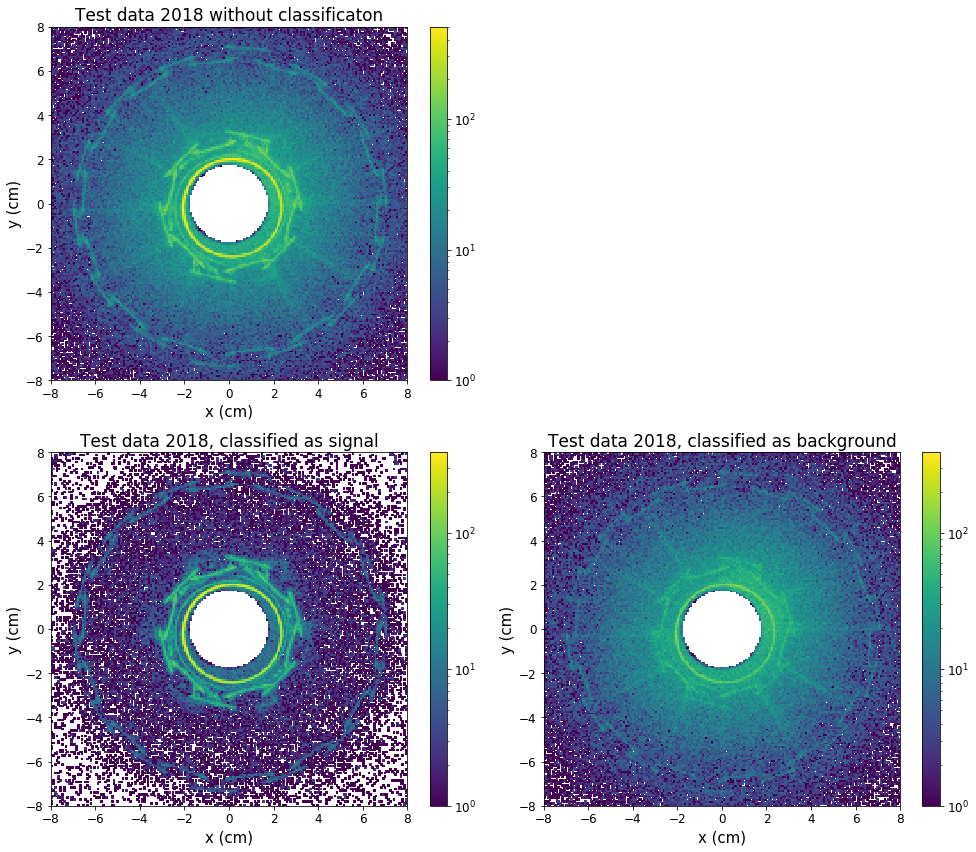

In [25]:
from matplotlib.colors import LogNorm

def PlotXY(x, y, Y_pred, Xmax, Tit, nb):
    # using the variable ax for single a Axes
    fig, ((ax, a_null),(bx,dx)) = plt.subplots(2,2, figsize=(14,12))
    fig.delaxes(a_null)
    #fig.delaxes(dx)
    num_bins = nb

# to add color pallete to figure: cmap = 'viridis' (default), 'jet'    
#     counts, xedges, yedges, im = ax.hist2d(x, y, bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm())
    counts, xedges, yedges, im = ax.hist2d(x, y, bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm(),
                                          cmap = 'viridis')
#     counts, xedges, yedges, im = ax.hist2d(x, y, bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]],cmap=plt.cm.jet, norm=LogNorm())

    counts, xedges, yedges, im2 = bx.hist2d(x[np.logical_and(Y_pred > -1, Y_pred < numSig)], 
                                           y[np.logical_and(Y_pred > -1, Y_pred < numSig)], bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm())


    counts, xedges, yedges, im3 = dx.hist2d(x[np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses)], 
                                           y[np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses)], bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm())

    vmin, vmax = im2.get_clim()
    #im2.set_clim(vmin, vmax)
    im3.set_clim(vmin, vmax)
    plt.colorbar(im, ax=ax)
    plt.colorbar(im2, ax=bx)
    plt.colorbar(im3, ax=dx)

#     # set all of them to the same scale and max/2
#     vmin, vmax = im.get_clim()
#     im.set_clim(vmin, int(vmax/2))
#     im2.set_clim(vmin, int(vmax/2))
#     im3.set_clim(vmin, int(vmax/2))
#     plt.colorbar(im, ax=ax)
#     plt.colorbar(im2, ax=bx)
#     plt.colorbar(im3, ax=dx)
    

#     cax,kw = matplotlib.colorbar.make_axes([ax, bx, dx], location='right')
#     plt.colorbar(im, cax=cax, **kw)

#     fig.colorbar(im, ax=[ax,bx,dx])
    
    Xtitle = 'x (cm)'
    Ytitle = 'y (cm)'
    ax.set_xlabel(Xtitle)
    ax.set_ylabel(Ytitle)
    ax.set_title(Tit + " data 2018 without classificaton")
    bx.set_xlabel(Xtitle)
    bx.set_ylabel(Ytitle)
    bx.set_title(Tit + " data 2018, classified as signal")
    dx.set_xlabel(Xtitle)
    dx.set_ylabel(Ytitle)
    dx.set_title(Tit + " data 2018, classified as background")
#     ax.legend(['Signal prediction', 'Background prediction'], loc='upper right')
    
#     bx.set_xlabel(Xtitle, fontsize=fsize)
#     bx.set_ylabel(Ytitle, fontsize=fsize)
#     bx.set_title("Signal prediction for "+ Tit + " data by category: L2, L3 and L4", fontsize=fsize)
#     bx.legend(['L2 prediction', 'L3 prediction', 'L4 prediction'], loc='upper right', fontsize=fsize)


    #plt.xscale('log')
    #plt.yscale('log')
    fig.tight_layout()
    plt.savefig('Results/' + ModelName + '_' + Tit + '_XY_Pred.pdf')
    plt.show()

#PlotXY(X_Test[:,1], X_Test[:,2], Y_Test_pred, 25.,"Test", 1250)
# PlotXY(X_Test[:,1], X_Test[:,2], Y_Test_pred, 4.,"Test", 200)
PlotXY(X_Test[:,1], X_Test[:,2], Y_Test_pred, 8.,"Test", 200)
#PlotXY(X_Test[:,1], X_Test[:,2], Y_Test_pred, 25.,"Test", 625)
